In [52]:
import random
import numpy as np
import torch

# Set some seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the torch device to use
device = torch.device('cuda:0')

In [53]:
import sys
sys.path.insert(0, "../")

## Semantic loss using `cirkit`

So far, we used our logic circuit in a *traditional* setting, by running queries related to its logical semantics. However, logic circuits also enable neuro-symbolic methods! In this notebook, we implement the **semantic loss** [(Xu et al, 2018)](https://proceedings.mlr.press/v80/xu18h.html), which relies on a logic circuit to implement contraints on the predictions of a neural network, using an SDD.

Imagine we want to enforce constraints on the output $\hat{y}$ of a neural network and we want to model those contraints as a logic formula $F$ by considering each element of $\hat{y}$ as a literal in $F$. We can compile the formula $F$ into a logic circuit $\texttt{c}$ and we can efficiently perform a bunch of operations on it (see [logic circuits](../logic-circuits)), but can we actually use the values of $\hat{y}$ as inputs to $\texttt{c}$? Or in other words, can we quantify if the input $\texttt{y}$ is a model for $\texttt{c}$ ($\texttt{y} \models \texttt{c}$)?

And even more importantly, since $\texttt{y}$ is a probability distribution, can we evaluate how likely it is to satisfy the constraint $\texttt{c}$? The answer is yes, by performing the Weighted Model Count of the formula $\texttt{c}$ where the weights are provided by $\texttt{y}$.

Building on this idea, the semantic loss is defined as $\mathcal{L}_{s}^\texttt{c}(\hat{y}) = -\texttt{c}(\hat{y})$.
It is a plug-and-play loss: if we have our favourite loss function $\mathcal{L}(y, \hat{y})$, where $y$ are the target prediction, we can combine them as $\mathcal{L}' = \mathcal{L}(y, \hat{y}) + \gamma \mathcal{L}_{s}^\texttt{c}(\hat{y})$ where $\gamma$ is the *importance* that we give to logically correct predictions. Minimizing $\mathcal{L}'$ means finding a model that minizes our favourite loss $\mathcal{L}$ while maximing the logical consistency of the predictions $\hat{y}$.

In this notebook, we follow one of the experiments on [(Xu et al, 2018)](https://proceedings.mlr.press/v80/xu18h.html) and implement a constraint that enforces mutual exclusivity between predictions. If we have a set $N = \{ C_1, C_2, \cdots, C_n \}$ of classes, then our logic formula will look like

$$
\alpha = (\lor_{C \in N} [C]) \land (\land_{C \neq D \in N } \lnot [C] \lor \lnot [D])
$$

where $[C]$ is the literal that corresponds to the class $C$ in the logic formula (and the circuit $\texttt{c}$).

Let's implement the logic circuit in `cirkit` first. We first define the constraint $\alpha$ with $|N| = 10$.

In [54]:
from operator import and_, or_
from functools import reduce
from itertools import combinations

from pysdd.sdd import Vtree, SddManager

N = 10

# define the SDD literals
vtree = Vtree(N, list(range(1, N + 1)), "balanced")
manager = SddManager.from_vtree(vtree)
alpha = reduce(or_, manager.vars) & reduce(and_, (~a | ~b for a, b in combinations(manager.vars, 2)))

And then we compile it to a boolean circuit. Before doing so, however, we have to clarify a little bit how and why the semantic loss works. If a logic circuit is decomposable and deterministic, we can replace its conjunctions and disjunctions with products and sums and its literals with indicator functions. This is the kind of translation `cirkit` relies upon internally.

Since the inner components of the circuit are sums and products, its inputs (the literals of the original logic formula) will be numbers. If we use indicator functions to model assignment to a literal, we obtain an arithmetic circuit whose support is the same as the boolean circuit. We will just have output $0$ instead of $\bot$ (false) and $1$ instead of $\top$ (true).

Luckily, we are not forced into using indicator functions to model inputs. 

If the input value represents a natural number, we can compute the Weighted Model Count of a logic formula and if we choose the input value carefully, we can perform probabilistic inference [(Chavira and Darwiche, 2008)](https://www.sciencedirect.com/science/article/pii/S0004370207001889).

In that case, we obtain a **probabilistic circuit** whose support is only the set of assignments that are also model for the logic formula $F$. Intuitively, we use the value $p \in [0, 1]$ for the input $[C]$ and the value $1 - p$ for the input $[\lnot C]$. The output of the circuit $\texttt{c}(\hat{y}) = 1.0$ only if $[\hat{y}] \models F$. Additionally, we will have that $\texttt{c}(y) \in [0, 1)$ is the probability that the assignment $\hat{y}$ is a model for $F$. In other words we can evaluate the probability that the $\hat{y}$ is consistent with the constraint imposed by $F$.

Let's see how to compile $\texttt{c}$ in `cirkit`. We first create our logic circuit and use as its inputs an `EmbeddingLayer`. Differently from the other notebooks, a `EmbeddingLayer` does not represent a tractable probability distribution, but rather assigns a tensor output to the discrete inputs to the circuit. By parameterizing the `EmbeddingLayer` through the predictions of the neural network, we delegate the responsibility of figuring out the weights of each literal to the neural network.

In [55]:
from tempfile import NamedTemporaryFile
from cirkit.templates.logic import SDD
from cirkit.symbolic.layers import EmbeddingLayer
from cirkit.symbolic.parameters import Parameter, ConstantParameter
from cirkit.symbolic.io import plot_circuit

from IPython.display import Image

with NamedTemporaryFile() as f:
    # export the SDD to a file
    alpha.save(f.name.encode())
    f.flush()

    # parse the SDD representation using the SDD class
    alpha_sdd = SDD.load(f.name)

    # define the literal factory which assigns to each literal a fixed input
    # we use the value [0.0, 0.0] as the value assigned to both states
    # right now, this value is irrelevant since we will parametrize using an
    # external tensor later
    def embedding_input_factory(scope, num_units):
        return EmbeddingLayer(
            scope,
            num_output_units=num_units,
            num_states=1,
            weight=Parameter.from_input(ConstantParameter(1, 1, value=np.array([[0.0,]]))),
        )

    alpha_symbolic = alpha_sdd.build_circuit(
        literal_input_factory=embedding_input_factory,
        negated_literal_input_factory=embedding_input_factory,
    )

We can create the propbabilistic circuit with inputs parametrized by the output of a neural network by constructing a conditional (probabilistic) circuit. A conditional circuit is a circuit where some of its parameters are parametrized through the use of a gate function [(Shao et al, 2022)](https://www.sciencedirect.com/science/article/pii/S0888613X21001766). A gate function is a general function that takes an arbitrary input and outputs a parameter for the circuit. In our case, we will only parametrize the input `EmbeddingLayer`s.

We can do this in `cirkit` by using the `condition_circuit` function, which takes as input the set of layers that we wish to parametrize.

In [56]:
from cirkit.templates.logic import LiteralNode, NegatedLiteralNode
from cirkit.symbolic.functional import condition_circuit

# we enforce an order on the literals to match the order of the predictions
parametrization_map = {
    "pos": sorted(
        (i for i in alpha_symbolic.inputs if isinstance(i.metadata["logic"]["source"], LiteralNode)),
        # we can access which originated this input using the metadata object of an input layer
        key=lambda i: i.metadata["logic"]["source"].literal,
    ),
    "neg": sorted(
        (i for i in alpha_symbolic.inputs if isinstance(i.metadata["logic"]["source"], NegatedLiteralNode)),
        key=lambda i: i.metadata["logic"]["source"].literal,
    ),
}

# conditionally parametrize alpha by using the external gate function
conditional_alpha_symbolic, gf_specs = condition_circuit(alpha_symbolic, gate_functions=parametrization_map)

for gf_k, gf_shape in gf_specs.items():
    print(f"Parameters {gf_k} need shape {gf_shape}")

Parameters pos.weight.0 need shape (10, 1, 1)
Parameters neg.weight.0 need shape (10, 1, 1)


Recall that the semantic loss computes the WMC of a formula parameterized by a neural network. We can perform this operation in advance on the symbolic circuit, by using the integration function provided by `cirkit`.

In [57]:
from cirkit.symbolic.functional import condition_circuit, integrate
wmc_circuit = integrate(conditional_alpha_symbolic)

We will need two different gate functions: one parametrizing the positive literals (corresponding to the classes $N$) and one parametrizing the negated literals (corresponding to the set $\{ \lnot C : C \in N \}$). Both gate function are required to produce similar parameter. Moreover, they will both take as input the prediction $\hat{y}$, since the parameters of $[C]$ and $[\lnot C]$ are a function of an element in $\hat{y}$.

In `cirkit` we instruct the compiler to use our provided gate function to parametrize the input layers and regularly compile the circuit.

In [58]:
from functools import partial
from cirkit.pipeline import PipelineContext

ctx = PipelineContext(backend="torch", semiring="sum-product")

def literal_gf(shape, p):
    # parameterize the positive inputs by using the output of the neural network 
    return p.view(-1, *shape)

# positive literals are parametrized by the raw output of the neural network
ctx.add_gate_function("pos.weight.0", partial(literal_gf, gf_specs["pos.weight.0"]))
# negative literals are parametrized by the complement of raw output of the neural network
ctx.add_gate_function("neg.weight.0", partial(literal_gf, gf_specs["neg.weight.0"]))

circuit = ctx.compile(wmc_circuit)

Let's see if if works out. Suppose the labels refer to the MNIST dataset (see the **region-graphs-and-parametrisation.ipynb** to see how images look like).
It would not surprise us too much if some model made confusion between 4s and 9s.
Hence, $y$ and $\hat{y}$ might look like

$$
y = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] \\
\hat{y} = [0.0, 0.0, 0.0, 0.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.3]
$$

The model correctly predicts the correct number ($4$), but is not too confident with it. As a result, $\hat{y}$ does satisfies the mutual exclusivity constraint with a low probability, which we can compute as $\texttt{c}(\hat{y})$.

In [59]:
import torch
y_hat = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.3]).unsqueeze(0)
print(circuit(gate_function_kwargs={"pos.weight.0": {"p": y_hat}, "neg.weight.0": {"p": 1 - y_hat}}))

tensor([[0.5800]])


Indeed, the circuit does not evaluate to $1$ since the prediction is not fully consistent with the logic circuit. However we correctly have that $\texttt{c}(y) = 1.0$ since it satisfiess the mutual exclusivity constraint.

In [60]:
y = torch.tensor([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]).unsqueeze(0)
print(circuit(gate_function_kwargs={"pos.weight.0": {"p": y}, "neg.weight.0": {"p": 1 - y}}))

tensor([[1.]])


When the model places more probability mass on the correct prediction, we have an higher probability of satisfying the constraint. We can see this by building multiple one-hot encoded prediction for a random class $i \in N$, scale them by different factors $\lambda$ and use a softmax activation. We obtain a probability distribution where the amount of probability mass on the prediction $i$ depends on $\lambda$.

/tmp/ipykernel_2269011/3088543440.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x:.1f}" for x in l[::100]])


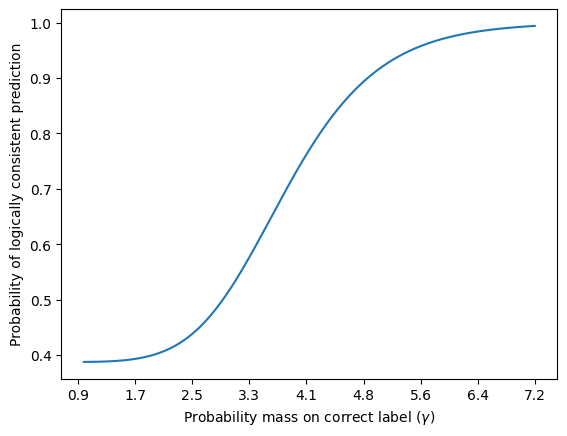

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

l = torch.linspace(0.1, 8, 1000)
preds = torch.zeros(1000, 10)
preds[torch.arange(1000), torch.randint(0, 10, size=(1000,))] = l
preds = preds.softmax(dim=-1)

logic_satisfaction = circuit(gate_function_kwargs={"pos.weight.0": {"p": preds}, "neg.weight.0": {"p": 1 - preds}})
logic_satisfaction = logic_satisfaction.detach().flatten()

ax.plot(l, logic_satisfaction)
ax.set_xticklabels([f"{x:.1f}" for x in l[::100]])

ax.set_xlabel(r"Probability mass on correct label ($\gamma$)")
ax.set_ylabel("Probability of logically consistent prediction")
plt.show()

Clearly, the more probability mass we have on the correct prediction, the more likely we are to have mutually exclusive predictions. Enforcing mutual exclusivity forces a model to be more confident in its predictions.

We can see if this enhances the performances of a neural network on a classification task. We will try to solve the classic MNIST benchmark by using a neural network with one hidden layer. We will use a small neural network composed of an MLP with one hidden layer with $256$ hidden dimensions and a ReLU activation. This will allow us to see if, alongside obtaining consistent prediction, semantic loss allows a model to build more effective decision boundaries.

We will experiment in semi-supervised setting: can we exploit just few labels to generalize to the entire dataset?
We will do so by considering each label independently, and hence train by using binary cross entropy as loss $\mathcal{L}$ with a sigmoid activation on the final state of the MLP. 

We will randomly remove the label to a sample with probability $0.9999$. Hence we will end up training on a very small set of samples. In the standard setting, this does not make too much difference than training on a bigger dataset.

When enforcing constraints, however, we can still compute the semantic loss over samples without any label! This will make sure the model is confident on its prediction, even though we cannot really tell it if its prediction is the right one. 

We will use $\gamma = 0.005$ as the semantic loss weight.

In [79]:
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2

class SemisupervisedMNIST(datasets.MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # mantain label of some samples
        self._supervised_idxs = torch.rand(len(self)) <= 0.01
    
    def __getitem__(self, idx: int):
        sample, label = super().__getitem__(idx)
        return sample, label, self._supervised_idxs[idx]

# Load the MNIST data set and data loaders
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
data_train = SemisupervisedMNIST('datasets', train=True, download=True, transform=transform)
data_test = SemisupervisedMNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
    nn.Sigmoid()
).to(device)

# Initialize a torch optimizer of your choice
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# move circuit to device
circuit = circuit.to(device)

We first evaluate how the MLP model performs on the task without any semantic loss. At each epoch we evaluate the accuracy of the predictions as well as the average probability of the predictions being consistent with $F$.

In [80]:
num_epochs = 10
respects_mutex = 0.0
correct_predictions = 0.0
running_samples = 0

for epoch_idx in range(num_epochs):
    for i, (x, y, supervised) in enumerate(train_dataloader):
        # compute the predictions using the MLP
        pred = mlp(x.to(device))

        # on the baseline, our loss is simply cross entropy
        # only compute loss on supervised examples
        loss = torch.nn.functional.binary_cross_entropy(
            pred[supervised], 
            torch.nn.functional.one_hot(y[supervised], num_classes=10).float().to(device)
        )

        # Update the parameters of the circuits, as any other model in PyTorch
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # compute the accuracy and logical correctness on the testing set
    correct_predictions = 0.0
    logically_correct_predictions = 0.0
    for x, y, _ in test_dataloader:
        with torch.no_grad():
            pred = mlp(x.to(device))
            correct_predictions += (pred.argmax(dim=-1) == y.to(device)).sum()

            # we compute the logical consistency of the predictions by measuring the probability
            # that they satisfy the logic formula
            logically_correct_predictions += circuit(
                gate_function_kwargs={
                    "pos.weight.0": {"p": pred}, 
                    "neg.weight.0": {"p": 1 - pred}}
            ).sum().cpu().item()
    
    logic_accuracy = logically_correct_predictions / len(data_test)
    accuracy = correct_predictions / len(data_test)
    print(f"Epoch: {epoch_idx} | Accuracy: {accuracy:.3f} | Constraint accuracy: {logic_accuracy:.3f}")

Epoch: 0 | Accuracy: 0.734 | Constraint accuracy: 0.506
Epoch: 1 | Accuracy: 0.809 | Constraint accuracy: 0.620
Epoch: 2 | Accuracy: 0.785 | Constraint accuracy: 0.663
Epoch: 3 | Accuracy: 0.864 | Constraint accuracy: 0.729
Epoch: 4 | Accuracy: 0.872 | Constraint accuracy: 0.763
Epoch: 5 | Accuracy: 0.856 | Constraint accuracy: 0.749
Epoch: 6 | Accuracy: 0.882 | Constraint accuracy: 0.797
Epoch: 7 | Accuracy: 0.878 | Constraint accuracy: 0.807
Epoch: 8 | Accuracy: 0.879 | Constraint accuracy: 0.811
Epoch: 9 | Accuracy: 0.879 | Constraint accuracy: 0.820


Of course the model achieves some level of logical consistency, but it is not a priority. Let's see what happens when we explicitly enforce mutual exclusivity.

In [81]:
# reset the parameters of the MLP
for layer in mlp:
    if len(list(layer.parameters())) > 0:
        layer.reset_parameters()

respects_mutex = 0.0
correct_predictions = 0.0

losses = []
for epoch_idx in range(num_epochs):
    for i, (x, y, supervised) in enumerate(train_dataloader):
        # compute predictions and cross entropy loss as in the baseline
        pred = mlp(x.to(device))        
        loss = torch.nn.functional.binary_cross_entropy(
            pred[supervised], 
            torch.nn.functional.one_hot(y[supervised], num_classes=10).float().to(device)
        )

        # and compute the semantic loss on all examples, we are not restricted to supervised ones
        semantic_loss = circuit(
            gate_function_kwargs={
                'pos.weight.0': {'p': pred}, 
                'neg.weight.0': {'p': 1 - pred}
        }).mean()
        
        # the overall loss is a simple combination of loss and semantic loss
        losses.append((loss, semantic_loss))
        loss = loss - (0.5 * semantic_loss)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    correct_predictions = 0.0
    logically_correct_predictions = 0.0
    for x, y, _ in test_dataloader:
        with torch.no_grad():
            pred = mlp(x.to(device))
            correct_predictions += (pred.argmax(dim=-1) == y.to(device)).sum()
            
            logically_correct_predictions += circuit(
                gate_function_kwargs={
                    'pos.weight.0': {'p': pred}, 
                    'neg.weight.0': {'p': 1 - pred}
            }).sum().item()

    logic_accuracy = logically_correct_predictions / len(data_test)
    accuracy = correct_predictions / len(data_test)
    print(f"Epoch: {epoch_idx} | Accuracy: {accuracy:.3f} | Constraint accuracy: {logic_accuracy:.3f}")

Epoch: 0 | Accuracy: 0.749 | Constraint accuracy: 0.737
Epoch: 1 | Accuracy: 0.820 | Constraint accuracy: 0.785
Epoch: 2 | Accuracy: 0.862 | Constraint accuracy: 0.836
Epoch: 3 | Accuracy: 0.871 | Constraint accuracy: 0.869
Epoch: 4 | Accuracy: 0.891 | Constraint accuracy: 0.885
Epoch: 5 | Accuracy: 0.889 | Constraint accuracy: 0.898
Epoch: 6 | Accuracy: 0.881 | Constraint accuracy: 0.889
Epoch: 7 | Accuracy: 0.896 | Constraint accuracy: 0.915
Epoch: 8 | Accuracy: 0.898 | Constraint accuracy: 0.921
Epoch: 9 | Accuracy: 0.899 | Constraint accuracy: 0.926


The model's predictions are more consistent with the constraint, however the model has to balance between optimizing weights for correct or consistent predictions.

The parameter $\gamma$ plays a big role on balancing the trade-off between accurate predictions and logically consistent predictions. Try different values to see if you can find a sweet spot. For comparison, the original semantic loss paper uses small weights for $\mathcal{L}_{SL}$ with $\lambda = 0.005$.